In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random as rnd
from random import randint
from scipy.stats import entropy
from math import e
from matplotlib.colors import ListedColormap

In [75]:
class CSRCA:
    def __init__(self, x_max, y_max):
        """  Constructor of the CAR CA Sets:
                the dimensions of the vegitaive array
                the values of probabilities for each growth seeed and tissue for each 7 functional types plus the empty
                the inital values for t_now and t_x used to point to the first time dimention of the vegitaive array
            
            the integer values in the vegitaive array are:
            0: empty 1:C 2:S 3:R 4:CS 5:CR 6:SR 7:CSR
            
            2 is added to the value of the size of the two spatial dimensions of the vegetation array  as a buffer to avoid edge effects.
            Keyword arguments:
            x_max -- size of the second dimension vegetation array
            y_max -- size of the third dimension vegetation array
        """
        self.x_max = x_max
        self.y_max = y_max
        self.grow   = [0.0,  0.8,  0.1,  0.1,  0.45,  0.45,  0.1,  0.33]
        self.tissue = [0.0,  0.1,  0.8, 0.1,  0.45,  0.1,  0.45,  0.33]
        self.seed   = [0.0,  0.1,  0.1,  0.8,  0.1,  0.45,  0.45,  0.33]
        self.t_now = 0
        self.t_next = 1
        self.vegetation =  [[[0 for _ in range(self.x_max+3)  ] for _ in range(self.y_max+3)]for _ in range(2)]
        self.stress =  [[0 for _ in range(self.x_max+3)  ] for _ in range(self.y_max+3)]
        self.disturbance =  [[0 for _ in range(self.x_max+3)  ] for _ in range(self.y_max+3)]
        self.clear()
        #print(self.vegetation[0])
        #self.print_g()
        
    def print_g(self):
        for t in range(2):
            for x in range(0,self.x_max):
                for y in range(1,self.y_max):
                    print(x,y,self.vegetation[t][x][y])         
        
    def clear(self):
        self.vegetation =  [[[0 for _ in range(self.x_max+3)  ] for _ in range(self.y_max+3)]for _ in range(2)]
        for t in range(2):
            for x in range(1,self.x_max+1):
                for y in range(1,self.y_max+1):
                    self.vegetation[t][x][y]=randint(0,7)
    
    
    def veg_death(self,x,y):
        """  The veg_death function destroys all vegitaion within a cell of the vegetation array
        
            Keyword arguments:
            x -- position in second dimension of the vegitaion array
            y -- position in thiry dimension of the vegitaion array
        """
        self.vegetation[self.t_now][x][y] =0    
        self.vegetation[self.t_next][x][y] =0
    
    def maintain(self,x,y,resource):
        """ The maintain function determines if the vegetation at a point x,y and t_now will be copied to the point
            x,y and t_next. 
            
            Keyword arguments:
            x -- position in second dimension of the  vegetation array
            y -- position in thiry dimension of the vegetation array
            resource -- the upper value of the probability of there being resources at this position 
        """
        if((rnd.random()<resource) or (rnd.random()<self.tissue[self.vegetation[self.t_now][x][y]])):
            self.vegetation[self.t_next][x][y] = self.vegetation[self.t_now][x][y]
        else:
            self.veg_death(x,y)
            
    def growth(self, x,y,seedrain):
        """ The growth function determines if an empty cell will be occupied by a neighbouring cell by either
        vegitative graowth or by seed germination
        The choice of neighbour is by weighted roulete wheele

        x -- position in second dimension of the  vegetation array
        y -- position in thiry dimension of the vegetation array

        """
        for _ in range(3):
            rx = x+rnd.randint(-1,1)
            ry = y+rnd.randint(-1,1)
            c = self.vegetation[self.t_now][rx][ry]
            g =self.grow[c]
            if rnd.random()<g:
                self.vegetation[self.t_next][x][y]=c;
                break;


        k=0
        if(self.vegetation[self.t_next][x][y]==0):
            for _ in range(9):
                rx = x + rnd.randint(-1, 1)
                ry = y + rnd.randint(-1, 1)
                c = self.vegetation[self.t_now][rx][ry]
                g = self.seed[c]
                if rnd.random() < g:
                    self.vegetation[self.t_next][x][y] = c;
                    break;
       
        if(self.vegetation[self.t_next][x][y]==0):
            if rnd.random()<seedrain:
                self.vegetation[self.t_next][x][y]=randint(1,7)
       
                
    def iterate(self, sflex,dflex, seedrain,show):
        counts = [0,0,0,0,0,0,0,0]
        tstress =  [[0 for _ in range(self.x_max+3)  ] for _ in range(self.y_max+3)]
        tdisturbance =  [[0 for _ in range(self.x_max+3)  ] for _ in range(self.y_max+3)]
        
        for x in range(1,self.x_max+1):
            for y in range(1,self.y_max+1):
                d = self.flexThis(self.disturbance[x][y]+dflex)
                s = self.flexThis(self.stress[x][y]+sflex)
                tstress[x][y]=s
                tdisturbance[x][y]=d
                if(rnd.random()<d):
                    self.veg_death(x,y)
                self.maintain(x,y,s)
        if show:
            print("--------------------------")
            print("Stress")
            plt.imshow(tstress,cmap='cool',vmax=1.0,vmin=0.0)
            plt.colorbar()
            plt.show()
            print("Disturbance")
            plt.imshow(tdisturbance,cmap='hot',vmax=1.0,vmin=0.0)
            plt.colorbar()
            plt.show()                
        for x in range(1,self.x_max+1):
            for y in range(1,self.y_max+1):
                s = self.flexThis(self.stress[x][y]+sflex)
                if(rnd.random()<s):
                    self.growth(x,y,seedrain)
                counts[self.vegetation[self.t_next][x][y]]+=1
        n= self.t_now;
        self.t_now=self.t_next;
        self.t_next=n;
        #print(self.t_now,self.t_next)
        return counts;

    def flexThis(self,value):
        n = value 
        if (n<0): 
            return 0
        if(n>1):
            return 1
        return n
        



    def run(self,exp):
        cmap = ListedColormap(["black","blue", "green", "red", "yellow","purple","orange","white"])
        results=[]
        reps = 1
        iterations=200
        resource = exp[1]
        disturbance = exp[2]
        flex = exp[3]
        block = exp[4]
        tempflex = exp[5]
        seedrain = exp[6]
        print(exp[0],resource,disturbance,flex,block)
        for x in range(1,self.x_max+1,block):
            for y in range(1,self.y_max+1,block):
#s = rnd.random()
#d = rnd.random()
                s =   (rnd.random()*2*flex)-flex 
                d =   (rnd.random()*2*flex)-flex
                

                for sx in range(block):
                    for sy in range(block):
                        self.stress[x+sx][y+sy]=resource + s#
                        self.disturbance[x+sx][y+sy]=disturbance + d
                        #+(rnd.random()*2*flex)-flex
                        #self.stress[x+sx][y+sy]=s#resource +(rnd.random()*2*flex)-flex
                        #self.disturbance[x+sx][y+sy]=d#disturbance +(rnd.random()*2*flex)-flex
        print("Stress:"+str(resource)+" Disturbence:"+str(disturbance))
        print("Stress")
        plt.imshow(self.stress,cmap='cool',vmax=1.0,vmin=0.0)
        plt.colorbar()
        plt.show()
        print("Disturbance)")
        plt.imshow(self.disturbance,cmap='hot',vmax=1.0,vmin=0.0)
        plt.colorbar()
        plt.show()
        for r in range(reps):
            self.clear()
            for t in range(iterations):
                countp=[0,0,0,0,0,0,0,0]
                result = [0]*19
                sflex = (rnd.random()*2*tempflex)-tempflex
                dflex = (rnd.random()*2*tempflex)-tempflex
                res = self.iterate(sflex,dflex,seedrain,((t+1)%50==0))
                result[0] = t+1
                result[1] = block
                result[2] = flex
                result[3] = resource
                result[4] = disturbance
                result[5] = tempflex
                result[6] = seedrain
                biomass = 0
                wbiomass = 0
                count = 0
                for c in range(len(res)):
                    result[c+7] =res[c]
                    countp[c] = res[c]
                    if ((res[c]>0) and (c>0)): # does not cout empty cells
                            count+=1
                            biomass+=res[c]
                            wbiomass +=res[c]*self.grow[c]
                result[15]=biomass
                result[16]=wbiomass
                result[17]=count
                if count>0:
                    result[18]=entropy(countp[1:], base=e)
                else:
                    result[18]=-1
                if ((t+1)%50==0):
                    resString=""
                    for i in range(18):
                        resString+= str(result[i])+","
                    if(result[18]==-1):
                        resString+= " "
                    else:
                        resString+= str(result[18])
                    #lock.acquire()
                    results.append(resString)
                    #lock.release()
                    plt.imshow(self.vegetation[self.t_now],cmap=cmap,vmax=7,vmin=0)
                    plt.colorbar()
                    plt.show()
                    print(t)
                    print()
        return results

In [93]:
ca = CSRCA(64,64)

1 0.46928186388871196 0.24488364919995043 0.1 8
Stress:0.46928186388871196 Disturbence:0.24488364919995043
Stress


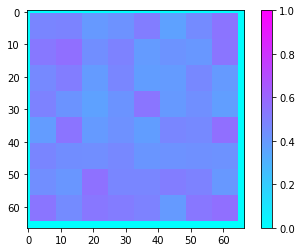

Disturbance)


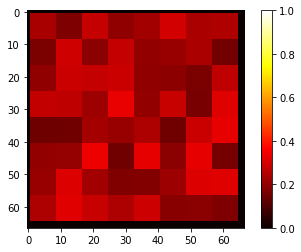

--------------------------
Stress


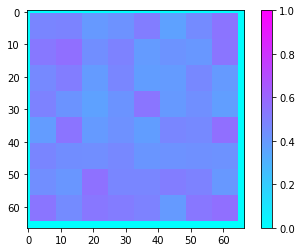

Disturbance


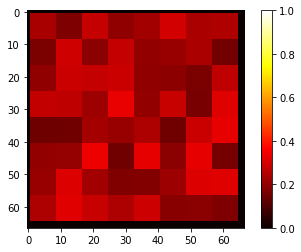

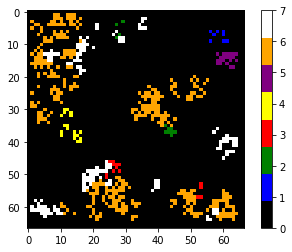

49

--------------------------
Stress


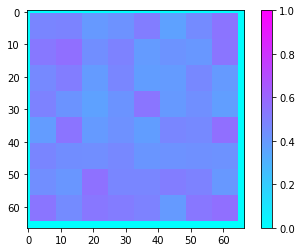

Disturbance


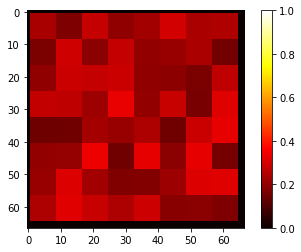

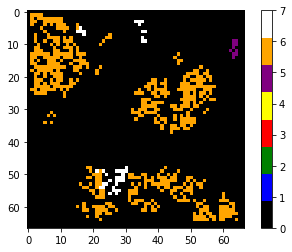

99

--------------------------
Stress


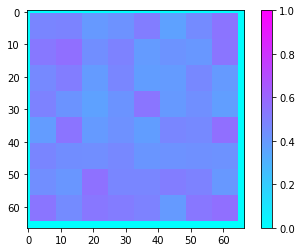

Disturbance


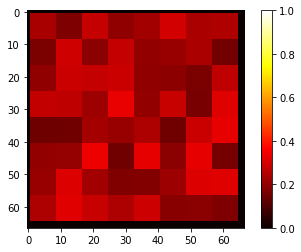

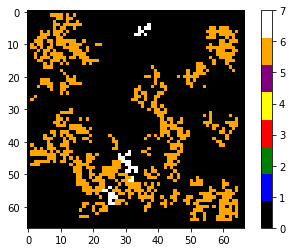

149

--------------------------
Stress


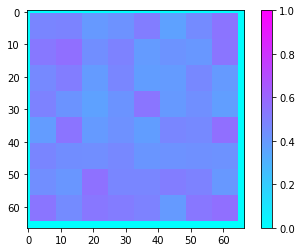

Disturbance


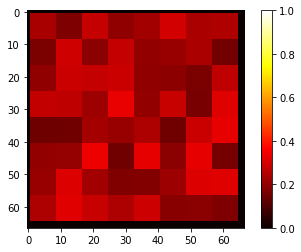

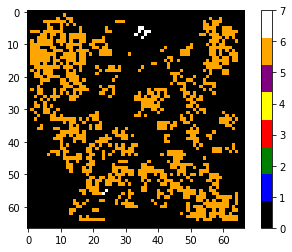

199



['50,8,0.1,0.46928186388871196,0.24488364919995043,0.0,0.0,3498,8,12,14,19,21,379,145,598,112.75,7,1.0838363376979805',
 '100,8,0.1,0.46928186388871196,0.24488364919995043,0.0,0.0,3446,0,0,0,0,10,599,41,650,77.93,3,0.3138277429881886',
 '150,8,0.1,0.46928186388871196,0.24488364919995043,0.0,0.0,3237,0,0,0,0,0,819,40,859,95.10000000000001,2,0.18827643905035402',
 '200,8,0.1,0.46928186388871196,0.24488364919995043,0.0,0.0,3004,0,0,0,0,0,1082,10,1092,111.5,2,0.05209329915494712']

In [97]:
 #                 r             d              f   b  tf   sr
ca.run([1, rnd.random(), rnd.random(),0.1,8,0.00,0.000])